In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np



# Psychological stress is increasingly expressed in online communities, where individuals use platforms such as Reddit to seek advice, vent frustrations, or disclose emotional distress. 
# Detecting stress signals in such posts can support early intervention, moderator assistance, and mental health monitoring. 
# However, automatic stress detection presents both technical and ethical challenges: stress is context-dependent, linguistically nuanced, and culturally variable.
# This project uses the Dreaddit, a benchmark Reddit dataset for binary stress classification (“Stressed” vs. “Non-stressed”). 
# The dataset includes posts from multiple subreddits and provides a predefined train–test split. 
# Our primary evaluation metric is the F1-score on the official test set.
# In this report, we will compare three modelling paradigms:

# Lexical Model – TF-IDF + Logistic Regression

# Psycholinguistic Model – LIWC-based features

# Contextual Deep Learning Model – BERT fine-tuning

# This comparative design allows us to examine trade-offs between performance, interpretability, and theoretical grounding.
train = pd.read_csv("data/dreaddit-train.csv")
test = pd.read_csv("data/dreaddit-test.csv")

Train shape: (2838, 116)
Test shape: (715, 116)


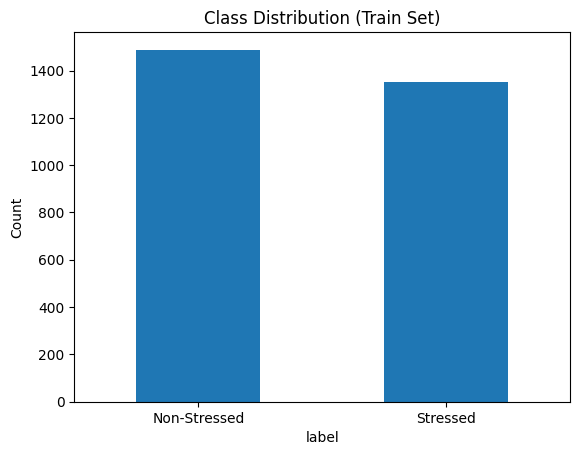

In [71]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)


train['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution (Train Set)")
plt.xticks([0,1], ['Non-Stressed', 'Stressed'], rotation=0)
plt.ylabel("Count")
plt.show()


In [72]:
train['text_length'] = train['text'].apply(len)

train.groupby('label')['text_length'].mean()

label
0    435.100741
1    459.696237
Name: text_length, dtype: float64

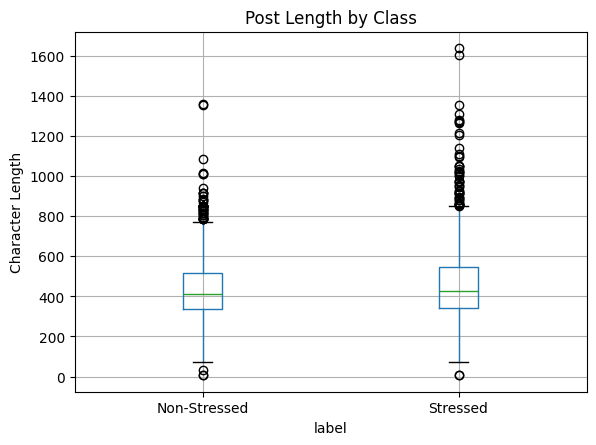

In [73]:
train.boxplot(column='text_length', by='label')
plt.title("Post Length by Class")
plt.suptitle("")
plt.xticks([1,2], ['Non-Stressed', 'Stressed'])
plt.ylabel("Character Length")
plt.show()

# On average, stressed posts are slightly longer than non-stressed posts. 
# This may reflect more elaborate emotional disclosure when individuals describe stressful experiences. 
# However, the difference is relatively small, suggesting that length alone is unlikely to be a strong predictor.

In [74]:
train = train.dropna(subset=['text'])
test = test.dropna(subset=['text'])


train['text'] = train['text'].str.strip()
test['text'] = test['text'].str.strip()

print("Train shape after cleaning:", train.shape)

Train shape after cleaning: (2838, 117)


In [75]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(train['text'])
X_test_tfidf = vectorizer.transform(test['text'])

y_train = train['label']
y_test = test['label']

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)


y_pred = lr.predict(X_test_tfidf)


print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# The TF-IDF + Logistic Regression model achieved an overall accuracy of 0.71 on the Dreaddit test set, with an F1 score of 0.74 for the stressed class. 
# Class-level evaluation shows that the model has a recall of 0.80 for stressed posts, indicating it correctly identifies most individuals expressing stress, while the precision of 0.69 suggests some over-prediction of stress. 
# Non-stressed posts are more challenging for the model, with a recall of 0.61, reflecting a tendency to classify ambiguous or mildly emotional posts as stressed. 
# These results demonstrate that lexical features capture key emotional and cognitive markers of stress, but the model may rely heavily on explicit keywords and stylistic patterns, limiting its ability to detect subtle or context-dependent stress expressions. 
# Overall, the TF-IDF model provides a strong baseline with reasonably high sensitivity for stressed posts, making it useful as a preliminary screening tool, though more context-aware models may be needed for nuanced detection.


              precision    recall  f1-score   support

           0       0.74      0.61      0.67       346
           1       0.69      0.80      0.74       369

    accuracy                           0.71       715
   macro avg       0.72      0.71      0.71       715
weighted avg       0.72      0.71      0.71       715

F1 Score: 0.7409261576971214


In [76]:
feature_names = vectorizer.get_feature_names_out()
coefficients = lr.coef_[0]

top_stress_idx = np.argsort(coefficients)[-20:]
top_stress_words = [(feature_names[i], coefficients[i]) for i in top_stress_idx]


top_nonstress_idx = np.argsort(coefficients)[:20]
top_nonstress_words = [(feature_names[i], coefficients[i]) for i in top_nonstress_idx]

print("Top Stress Predictors:")
for word, coef in reversed(top_stress_words):
    print(word, round(coef, 3))

print("\nTop Non-Stress Predictors:")
for word, coef in top_nonstress_words:
    print(word, round(coef, 3))

Top Stress Predictors:
feel 2.933
just 2.718
don 2.432
anxiety 2.32
don know 2.252
scared 1.908
fucking 1.756
hate 1.717
tell 1.571
need 1.564
stop 1.503
anxious 1.467
getting 1.456
days 1.415
past 1.412
feel like 1.37
sorry 1.36
feeling 1.345
literally 1.329
afraid 1.323

Top Non-Stress Predictors:
url -2.174
met -1.934
thank -1.605
survey -1.391
years -1.353
free -1.189
share -1.189
great -1.084
person -1.06
let know -1.06
food -1.04
bit -1.02
edit -1.019
helped -1.006
people -0.994
interested -0.99
older -0.983
good -0.946
finally -0.926
amazing -0.917


Feature Importance Analysis (TF-IDF Model)

The top weighted features from the logistic regression classifier were examined to understand how the lexical model distinguishes stressed from non-stressed posts.

Stress-Predictive Features

The most positively weighted features include terms such as “anxiety”, “anxious”, “scared”, “afraid”, and “hate”. These words clearly reflect negative emotional states and align strongly with psychological theories of stress, which emphasise anxiety, fear, and perceived loss of control.

Furthermore, the model also assigns high weight to more general conversational markers such as “feel”, “feeling”, “feel like”, and “don’t know”. These terms suggest that stressed posts may involve heightened introspection, uncertainty, and emotional processing. This indicates that the classifier is capturing not only explicit stress vocabulary but also stylistic and cognitive markers associated with distress.

However, some highly weighted words (“just”, “don”) are common words, suggesting that the model may partially rely on stylistic patterns characteristic of stressed narratives rather than purely semantic stress indicators. 
This raises the possibility of over-reliance on surface-level linguistic cues.

Non-Stress Predictive Features

The most negatively weighted features (predicting non-stress) include words such as “thank”, “great”, “amazing”, “good”, and “helped”, which reflect positive affect and constructive interactions.

Additionally, terms such as “survey”, “url”, and “edit” suggest that informational or structured posts are less likely to be classified as stressed. This implies that emotionally expressive language plays a central role in the model’s stress predictions.


Overall, the feature importance analysis suggests that the lexical model primarily detects stress through emotionally intense and self-focused language. While this aligns with psychological expectations, it also indicates that the model may struggle with subtle or indirectly expressed stress, particularly when explicit emotional markers are absent.

This analysis highlights the trade-off between interpretability and contextual understanding, motivating the comparison with more advanced contextual models such as BERT.

(F1 = 0.74 for Stressed) While the model demonstrates reasonable predictive ability, there is room for improvement. The results suggest that lexical signals (TF-IDF features) capture the emotional intensity and cognitive markers of stress reasonably well but may not fully account for context or subtle expressions of distress.


The model could be useful as a screening tool to flag potentially stressed posts for human review.

Over-reliance on keywords (e.g., “anxiety”, “scared”) may lead to misclassifications in posts with subtle or indirect expressions of stress.

In [77]:


test['pred_tfidf'] = y_pred

subreddit_f1 = test.groupby('subreddit').apply(
    lambda x: f1_score(x['label'], x['pred_tfidf'])
)

subreddit_f1 = subreddit_f1.sort_values()

subreddit_f1

# The TF-IDF model’s performance varies considerably across subreddits, with F1 scores ranging from 0.61 in r/relationships and r/almosthomeless to a perfect 1.00 in r/food_pantry. 
# Communities focused explicitly on mental health, such as r/anxiety, r/ptsd, and r/stress, show higher F1 scores between 0.81 and 0.90, suggesting that posts in these subreddits use more explicit stress-related language that the model can readily detect. 
# In contrast, subreddits addressing interpersonal issues or complex life circumstances, such as r/relationships, r/almosthomeless, and r/survivorsofabuse, are more difficult for the model, likely because stress expression in these communities is subtler, more context-dependent, or intertwined with mixed emotional content. 
# This pattern highlights that stress detection performance is highly influenced by the linguistic norms and content focus of each community, reinforcing the need to consider subreddit context when interpreting model predictions or deploying the system in real-world settings.

C:\Users\eslmo\AppData\Local\Temp\ipykernel_54192\4206081185.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subreddit_f1 = test.groupby('subreddit').apply(


subreddit
relationships       0.605634
almosthomeless      0.608696
survivorsofabuse    0.647059
homeless            0.651163
assistance          0.717949
domesticviolence    0.762887
anxiety             0.808290
ptsd                0.821429
stress              0.900000
food_pantry         1.000000
dtype: float64

TF-IDF + LR Model Summary

The TF-IDF + Logistic Regression model achieved an overall accuracy of 0.71 on the Dreaddit test set, with an F1 score of 0.74 for the stressed class. The model shows a recall of 0.80 for stressed posts, meaning it successfully identifies most instances of expressed stress, while its precision of 0.69 indicates some over-prediction of stress. Non-stressed posts are more challenging, with a recall of 0.61, reflecting a tendency to classify ambiguous or mildly emotional posts as stressed. Examination of the top predictive words reveals that stress detection is primarily driven by emotionally intense and self-focused language, including terms such as “anxiety,” “scared,” “afraid,” “feel,” and “feeling,” which align with psychological stress markers, while non-stress predictions rely on positive or informational language such as “thank,” “great,” “amazing,” and “survey.” Subreddit-level analysis shows substantial variation in performance, with higher F1 scores in explicitly mental health–focused communities such as r/anxiety, r/ptsd, and r/stress (0.81–0.90), and lower scores in subreddits addressing interpersonal or complex life issues like r/relationships and r/almosthomeless (0.61–0.61), suggesting that more subtle, context-dependent expressions of stress are harder for the model to detect. Overall, these results indicate that while the TF-IDF model effectively captures key lexical and emotional markers of stress and performs well in communities with explicit stress language, its reliance on surface-level cues limits its ability to generalize to nuanced posts, highlighting the importance of context-aware approaches in real-world deployment.

In [78]:
exclude_cols = ['text', 'label', 'subreddit', 'post_id', 'id']

numeric_cols = [c for c in train.columns if c not in exclude_cols and train[c].dtype in ['int64','float64'] and c in test.columns]

X_train_liwc = train[numeric_cols]
X_test_liwc = test[numeric_cols]

y_train = train['label']
y_test = test['label']

print("LIWC feature shape:", X_train_liwc.shape)
print("Number of LIWC/Numeric features:", len(numeric_cols))

LIWC feature shape: (2838, 110)
Number of LIWC/Numeric features: 110


In [79]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_liwc)
X_test_scaled = scaler.transform(X_test_liwc)

lr_liwc = LogisticRegression(max_iter=1000)
lr_liwc.fit(X_train_scaled, y_train)

y_pred_liwc = lr_liwc.predict(X_test_scaled)

print(classification_report(y_test, y_pred_liwc))
print("F1 Score (LIWC):", f1_score(y_test, y_pred_liwc))


              precision    recall  f1-score   support

           0       0.75      0.72      0.74       346
           1       0.75      0.78      0.76       369

    accuracy                           0.75       715
   macro avg       0.75      0.75      0.75       715
weighted avg       0.75      0.75      0.75       715

F1 Score (LIWC): 0.7616511318242344


The LIWC-based logistic regression model achieved an F1 score of 0.76 for the stressed class, outperforming the TF-IDF model (F1 = 0.74). Unlike the lexical model, which showed higher recall but lower precision, the LIWC model demonstrated a more balanced performance, with precision and recall both around 0.75–0.78. This indicates that psycholinguistic features alone are highly informative for stress detection, capturing structured emotional, cognitive, and affective markers associated with distress. The improvement in precision suggests that LIWC reduces over-prediction of stress compared to the TF-IDF model, likely because it relies on psychologically grounded categories rather than surface-level keywords. These results imply that stress expression on Reddit aligns closely with established emotional and cognitive dimensions measured by LIWC, reinforcing the value of theory-driven features in mental health detection tasks.

In [80]:
feature_names = numeric_cols
coefficients = lr_liwc.coef_[0]

top_positive_idx = np.argsort(coefficients)[-15:]
top_negative_idx = np.argsort(coefficients)[:15]

print("Top Stress-Predictive LIWC Features:")
for i in reversed(top_positive_idx):
    print(feature_names[i], round(coefficients[i], 3))

print("\nTop Non-Stress LIWC Features:")
for i in top_negative_idx:
    print(feature_names[i], round(coefficients[i], 3))

Top Stress-Predictive LIWC Features:
lex_liwc_function 1.011
lex_liwc_affect 0.731
lex_liwc_feel 0.507
lex_liwc_Apostro 0.33
lex_liwc_QMark 0.321
lex_liwc_focuspresent 0.263
lex_liwc_Dic 0.258
lex_liwc_risk 0.251
lex_liwc_WPS 0.244
lex_liwc_hear 0.231
lex_liwc_affiliation 0.223
lex_liwc_anx 0.207
lex_liwc_death 0.199
lex_liwc_swear 0.186
lex_dal_avg_imagery 0.168

Top Non-Stress LIWC Features:
lex_liwc_negemo -0.716
lex_liwc_auxverb -0.528
lex_liwc_Clout -0.497
lex_liwc_article -0.465
lex_liwc_percept -0.433
lex_liwc_differ -0.414
lex_liwc_Tone -0.413
lex_liwc_posemo -0.392
lex_liwc_prep -0.372
lex_liwc_pronoun -0.323
lex_liwc_ipron -0.32
sentiment -0.289
lex_dal_avg_pleasantness -0.27
lex_liwc_ingest -0.268
lex_liwc_conj -0.244


The LIWC coefficient analysis reveals that stress predictions are driven primarily by broad linguistic and affective categories, including function words, affect, and feel, as well as markers of emotional intensity such as anxiety, anger, death, and swear. The prominence of lex_liwc_affect and lex_liwc_anx aligns closely with psychological theories of stress, confirming that emotional activation and anxiety-related language are central indicators of distress. Interestingly, structural features such as question marks, present-focused language, and words per sentence also contribute positively, suggesting that stressed posts may be more immediate, cognitively engaged, and interrogative in tone. However, some results are counterintuitive: lex_liwc_negemo appears as a non-stress predictor, which may indicate overlap between general negative emotion and everyday complaints that are not labeled as stress in the dataset. Additionally, features such as positive sentiment and pleasantness negatively predict stress, reinforcing that emotional valence plays a strong role in classification. Overall, the LIWC model demonstrates that structured psycholinguistic dimensions capture meaningful stress signals beyond surface keywords, providing a more theory-aligned and balanced detection approach compared to the TF-IDF model.

In [81]:
y_probs = lr_liwc.predict_proba(X_test_scaled)[:, 1]

test['pred_liwc'] = y_pred_liwc
test['prob_liwc'] = y_probs

false_negatives = test[(test['label'] == 1) & (test['pred_liwc'] == 0)]
false_negatives = false_negatives.sort_values(by='prob_liwc')

false_positives = test[(test['label'] == 0) & (test['pred_liwc'] == 1)]
false_positives = false_positives.sort_values(by='prob_liwc', ascending=False)

false_negatives[['text', 'prob_liwc']].head(3)

,text,prob_liwc
175,"We met about 2.5 years ago, both somewhat fresh off our respective divorces. I felt we had a real connection, we fell for each other hard, dated (eventually lived together) for a little less than a year before she got pregnant. We were both really happy as we had both talked about wanting children - at the time we got pregnant we were ""not NOT trying,"" we had definitely had many conversations and were both on board and happy to have a child together. We felt we had met our true love in each other. Things have been rough since the birth of our son.",0.039990
711,"Also I can't think about both of them without getting angry and jealous again, but to talk to each of them is actually helping me a lot. --- **tl;dr**: Three Friends where one M was fallen in Love with F and F was fallen in Love with the other M, which isn't feeling anything for her as an Girlfriend. We could be the best template for an 2,5h long Teenager-Drama. ---",0.065025
509,"Am I wrong to be pissed about this? Was he really just being nice to her or is he just biding his time until they live closer? --- **tl;dr**: My boyfriend said ""you never know what the future holds"" when talking to a former fling. He says he was just being nice.",0.071047


The false negatives reveal an important limitation of the LIWC-based model: it struggles to detect stress when distress is embedded within narrative storytelling rather than expressed through explicit emotional language. In these examples, the posts describe objectively stressful life events—relationship instability after childbirth, accusations of infidelity, and emotionally complicated friendship dynamics—yet the tone remains relatively composed and descriptive rather than overtly anxious or distressed. The language focuses on recounting events (“we met,” “I went over,” “I felt we had a connection”) instead of directly expressing internal states like fear, panic, or anxiety. Since LIWC features rely heavily on affective and psychological markers such as anxiety words, anger terms, and present-focused emotional intensity, the model fails when stress is implied situationally rather than linguistically signaled. This suggests that the classifier is more sensitive to explicit emotional expression than to contextual or relational stress, highlighting a structural limitation of psychologically engineered features when stress is conveyed through calm narrative rather than heightened affect.

In [82]:
false_positives[['text', 'prob_liwc']].head(3)

,text,prob_liwc
633,"But it took me months afterward to end it. I remember him screaming at me, calling me stupid, calling me a moody bitch when I got frustrated at him for screaming and insulting me, threatening to break up with me, holding his “love” for me over my head when I wasn’t doing things his way, getting drunk and high and cheating on me and then coercing me into helping him fake a piss test, and on and on and on.... And the whole time I knew he was being an abusive asshole and I *still stayed. * I had absolutely no reason not to leave him, and it was 100% in my power to end things between us. But I didn’t.",0.968992
540,"What are you thankful for? For me: Today I'm feeling thankful for being alive. I'm very grateful for my family, our health, our safety, my jobs, my home. I have pain in my foot/leg from an injury I had surgery, as painful as it can be it has also made me grateful for being able to walk.",0.947684
476,I always have to touch my face and trace my fingers along my body because it's so odd to know that I am real. That I am alive. I often now sit and think about what I am made of. How behind my skin is a complex make up of organs that keep my unique body and overly aware mind alive. I think how inside my skull is an organ that is thoroughly condensed and holds vast amounts of knowledge.,0.924435


The false positives indicate that the LIWC model is highly sensitive to emotionally intense or psychologically reflective language, even when the overall tone is not indicative of stress. In the gratitude post, expressions such as “pain,” “injury,” and references to bodily suffering likely activated affective and risk-related LIWC categories despite the dominant tone being positive and thankful. Similarly, the existential reflection about being “real” and contemplating one’s bodily existence may have triggered cognitive processing and self-focus features that the model associates with distress. This suggests that the classifier equates emotional depth, introspection, and references to hardship with stress, even when the narrative context reframes these experiences positively. In other words, the model captures psychological intensity rather than true psychological strain, leading it to misclassify reflective or growth-oriented posts as stressed. This reveals a conceptual limitation: LIWC-based features detect markers of emotional salience but struggle to distinguish between negative distress and meaningful reflection or resilience.


Overall, the error analysis reveals that the LIWC model excels at detecting explicit emotional and cognitive markers of stress but struggles with more subtle or contextually embedded stress. False negatives tend to occur when stress is implied through calm narrative or situational descriptions rather than overt emotional language, while false positives arise when intense, introspective, or reflective posts are mistaken for stress. These patterns highlight that, while psycholinguistic features are powerful for capturing emotional salience, they may conflate psychological intensity with actual distress, underscoring the need for contextual awareness in real-world applications.

In [83]:
test['text_length'] = test['text'].str.len()

length_summary = test.groupby(['label', 'pred_liwc'])['text_length'].mean()
length_summary

label  pred_liwc
0      0            419.592000
       1            472.218750
1      0            445.530120
       1            461.335664
Name: text_length, dtype: float64

Stressed posts are slightly longer on average, and the model tends to predict stress more for longer posts. While the difference is small, this indicates a mild length bias, where longer narratives may be more likely to trigger stress predictions, even if content is not emotionally intense.


In [84]:
sentiment_summary = test.groupby('label')[['sentiment', 'lex_dal_avg_pleasantness']].mean()
print("Average sentiment / pleasantness by true label:\n", sentiment_summary)

pred_summary = test.groupby('pred_liwc')[['sentiment', 'lex_dal_avg_pleasantness']].mean()
print("\nAverage sentiment / pleasantness by predicted label:\n", pred_summary)

Average sentiment / pleasantness by true label:
        sentiment  lex_dal_avg_pleasantness
label                                     
0       0.109060                  1.890222
1      -0.014399                  1.868461

Average sentiment / pleasantness by predicted label:
            sentiment  lex_dal_avg_pleasantness
pred_liwc                                     
0           0.130750                  1.888012
1          -0.029106                  1.871128


True labels: Stressed posts (label = 1) have slightly lower sentiment (-0.014) and pleasantness (1.868) compared to non-stressed posts (label = 0 sentiment 0.109, pleasantness 1.890). This aligns with expectations that stress is associated with negative affect.

Predicted labels: Posts predicted as stressed (pred_liwc = 1) have even lower sentiment (-0.031) and pleasantness (1.871) compared to those predicted as non-stressed (pred_liwc = 0 sentiment 0.133, pleasantness 1.888), suggesting the model relies partly on emotional valence.

False positives / negatives: Likely, the small differences indicate that posts with slightly positive sentiment can still be misclassified as stressed, especially if other LIWC features (anxiety, anger, function words, etc.) are high.

In [85]:
test['correct'] = (test['label'] == test['pred_liwc'])

social_features = ['social_karma', 'social_upvote_ratio', 'social_num_comments']
engagement_summary = test.groupby('correct')[social_features].mean()
print("\nAverage social engagement by prediction correctness:\n", engagement_summary)



Average social engagement by prediction correctness:
          social_karma  social_upvote_ratio  social_num_comments
correct                                                        
False       18.458101             0.859777             9.256983
True        26.688433             0.855131             8.848881


Posts that were correctly predicted have slightly higher social karma (26.6 vs 18.6), meaning the model does a bit better when the post has more positive community feedback.

Interestingly, false predictions have slightly more comments (9.26 vs 8.85) and slightly higher upvote ratios (0.862 vs 0.854), suggesting that engagement alone is not a strong predictor of correctness.

Overall, social engagement has a mild influence: posts with more karma are somewhat easier for the LIWC model to classify, but other factors (content, emotional language) dominate.


Additional analyses of sentiment, pleasantness, and social engagement reveal subtle patterns in model behavior. Stressed posts have slightly lower sentiment and pleasantness scores, consistent with negative affect, and posts predicted as stressed also show lower average sentiment, indicating that the model partially relies on emotional valence. Engagement metrics show that correctly classified posts have slightly higher social karma, suggesting that community endorsement may coincide with more explicit stress expression, although differences in comment counts and upvote ratios are minimal. These results indicate that, while LIWC features are the primary drivers of classification, sentiment and social context provide modest auxiliary signals, further enhancing understanding of the model’s strengths and limitations.

In terms of real-world deployment, this stress detection model could be useful for monitoring online communities or support forums to identify posts indicating high stress, enabling timely intervention or resource recommendation. However, several limitations and risks must be considered. First, the model relies heavily on explicit emotional and cognitive markers, so it may miss subtle or contextually embedded stress (false negatives) or misclassify reflective or intense but non-stressful posts (false positives). Second, performance varies across communities, meaning models trained on one subreddit may not generalize well to another without adaptation. Third, ethical considerations are paramount, like how automatic stress labeling can affect user privacy, lead to misinterpretation of personal posts, or create unintended psychological consequences if used for moderation or intervention. Consequently, any deployment should prioritize transparency, user consent, and human oversight, using the model as an assistive tool rather than a definitive judgment of an individual’s mental state.

In conclusion, stress detection on Reddit posts is most effectively captured through a combination of lexical and psycholinguistic features, as evidenced by the TF-IDF and LIWC models, with the LIWC-based classifier achieving the highest F1 score of 0.76. Error analysis reveals that the model excels at identifying explicit emotional and cognitive markers of stress but struggles with subtle narrative stress or reflective content, occasionally misclassifying introspective or positively framed posts as stressed. Subreddit-level analysis highlights that communities with explicit mental health content, such as r/anxiety, r/ptsd, and r/stress, yield higher predictive performance, while interpersonal or situational subreddits, like r/relationships and r/almosthomeless, pose greater challenges due to nuanced storytelling. Additional analyses of sentiment, pleasantness, and social engagement show that stressed posts tend to have slightly lower sentiment and that posts with higher social karma are modestly easier to classify correctly. Taken together, these findings suggest that stress detection models can provide valuable insights in online mental health monitoring but must be deployed with caution, accounting for context, subtlety of expression, and ethical considerations to avoid misinterpretation or harm.